In [1]:
import os
import cv2
import numpy as np

from time import time
from tqdm import tqdm
from collections import OrderedDict
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, RandomSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn import Linear, Conv2d, Flatten, MaxPool2d, BatchNorm2d, Dropout

import torchvision.models as models
from torchvision import transforms as T

/home/wonje/anaconda3/envs/ML/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DIR_TRAIN = "./data/train"
DIR_VALID = "./data/valid"
DIR_TEST = "./data/test"

In [3]:
classes = os.listdir(DIR_TRAIN)
print("Total Classes: ",len(classes))

train_count = 0
valid_count = 0
test_count = 0

train_paths = []
valid_paths = []
test_paths = []

for _class in classes:
    for img in os.listdir(f"{DIR_TRAIN}/{_class}"):
        train_paths.append(f"{DIR_TRAIN}/{_class}/{img}")
        train_count += 1
    for img in os.listdir(f"{DIR_VALID}/{_class}"):
        valid_paths.append(f"{DIR_VALID}/{_class}/{img}")
        valid_count += 1
    for img in os.listdir(f"{DIR_TEST}/{_class}"):
        test_paths.append(f"{DIR_TEST}/{_class}/{img}")
        test_count += 1
class_to_int = {classes[i]: i for i in range(len(classes))}


Total Classes:  100


In [4]:
def getTransforms():
    return T.Compose([T.ToTensor()])

def getAugmentationTransforms():
    return T.Compose([
        T.ToTensor(),
        T.RandomHorizontalFlip(),
        T.RandomRotation([-20, 20]),
    ])
class ButterflyAndMothDataset(Dataset):
    def __init__(self, imgs_list, class_to_int, transforms=None):
        super().__init__()
        self.imgs_list = imgs_list
        self.class_to_int = class_to_int
        self.transforms = transforms
        
    def __getitem__(self, idx):
        img_path = self.imgs_list[idx]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.
        
        label = img_path.split("/")[-2]
        label = self.class_to_int[label]
        
        if self.transforms != None:
            img = self.transforms(img)
            
        return img, label
    
    def __len__(self):
        return len(self.imgs_list)

In [5]:
def create_data_set(isAug=False):
    train_dataset, valid_dataset, test_dataset = None, None, None
    if isAug:
        train_dataset = ButterflyAndMothDataset(train_paths, class_to_int, getAugmentationTransforms())
        valid_dataset = ButterflyAndMothDataset(valid_paths, class_to_int, getAugmentationTransforms())
        test_dataset = ButterflyAndMothDataset(test_paths, class_to_int, getAugmentationTransforms())
    else:
        train_dataset = ButterflyAndMothDataset(train_paths, class_to_int, getTransforms())
        valid_dataset = ButterflyAndMothDataset(valid_paths, class_to_int, getTransforms())
        test_dataset = ButterflyAndMothDataset(test_paths, class_to_int, getTransforms())
    
    train_random_sampler = RandomSampler(train_dataset)
    valid_random_sampler = RandomSampler(valid_dataset)
    test_random_sampler = RandomSampler(test_dataset)

    train_data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    sampler=train_random_sampler
    )
    valid_data_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=64,
        sampler=valid_random_sampler
    )
    test_data_loader = DataLoader(
        dataset=test_dataset,
        batch_size=50,
        sampler=test_random_sampler
    )
    return train_data_loader, valid_data_loader, test_data_loader

In [6]:
class FeatureExtractor(nn.Module):
    def __init__(self, n_layer, start_channel, n_channel, is_batch=True):
        super(FeatureExtractor, self).__init__()
        
        self.n_layer = n_layer
        self.n_channel = n_channel
        self.layers = nn.ModuleList()
        self.is_batch = is_batch
        
        ### conv layers
        
        # First layer (channel converting)
        self.layers.append(Conv2d(start_channel, n_channel, (3,3), padding='same'))
        if is_batch:
            self.layers.append(BatchNorm2d(self.n_channel))
            
        # Layers
        for i in range(n_layer-1):
            self.layers.append(Conv2d(n_channel, n_channel, (3,3), padding='same'))
            if is_batch:
                self.layers.append(BatchNorm2d(self.n_channel))
                
        # MaxPooling
        self.layers.append(nn.MaxPool2d((2,2)))
        

    def forward(self, x):
        
        for layer in self.layers[:-1]:
            if isinstance(layer, Conv2d):
                x = F.relu(layer(x))
            elif isinstance(layer, BatchNorm2d):
                x = layer(x)
            
        return self.layers[-1](x)
    
    def getName(self, number):
        return f"feature_extract_{number} ({self.n_channel})"
    
    
class Classifier(nn.Module):
    def __init__(self, is_dropout=False):
        super(Classifier, self).__init__()
        
        self.is_dropout = is_dropout
        
        self.dropout_1 = Dropout(0.4)
        self.fc_1 = nn.Linear(25088, 4096, bias=True)
        self.dropout_2 = Dropout(0.4)
        self.fc_2 = nn.Linear(4096, 4096, bias=True)
        self.classifier = nn.Linear(4096, 100, bias=False)
        
    def forward(self, x):
        x = Flatten()(x)
        if self.is_dropout:
            x = self.dropout_1(x)
        x = F.relu(self.fc_1(x))
        if self.is_dropout:
            x = self.dropout_2(x)
        x = F.relu(self.fc_2(x))
        return self.classifier(x)


In [7]:
def create_vgg11_model(is_batch=False, is_dropout=False):
    
    VGG11 = nn.Sequential(OrderedDict([
    ('block_1', FeatureExtractor(1, 3, 64, is_batch=is_batch)),
    ('block_2', FeatureExtractor(1, 64, 128, is_batch=is_batch)),
    ('block_3', FeatureExtractor(2, 128, 256, is_batch=is_batch)),
    ('block_4', FeatureExtractor(2, 256, 512, is_batch=is_batch)),
    ('block_5', FeatureExtractor(2, 512, 512, is_batch=is_batch)),
    ('classifier', Classifier(is_dropout=is_dropout))
    ]))
    
    return VGG11
 
def create_vgg16_model(is_batch=False, is_dropout=False):
    
    VGG16 = nn.Sequential(OrderedDict([
    ('block_1', FeatureExtractor(2, 3, 64, is_batch=is_batch)),
    ('block_2', FeatureExtractor(2, 64, 128, is_batch=is_batch)),
    ('block_3', FeatureExtractor(3, 128, 256, is_batch=is_batch)),
    ('block_4', FeatureExtractor(3, 256, 512, is_batch=is_batch)),
    ('block_5', FeatureExtractor(3, 512, 512, is_batch=is_batch)),
    ('classifier', Classifier(is_dropout=is_dropout))
    ]))
    
    return VGG16    

def create_vgg19_model(is_batch=False, is_dropout=False):
    
    VGG19 = nn.Sequential(OrderedDict([
    ('block_1', FeatureExtractor(2, 3, 64, is_batch=is_batch)),
    ('block_2', FeatureExtractor(2, 64, 128, is_batch=is_batch)),
    ('block_3', FeatureExtractor(4, 128, 256, is_batch=is_batch)),
    ('block_4', FeatureExtractor(4, 256, 512, is_batch=is_batch)),
    ('block_5', FeatureExtractor(4, 512, 512, is_batch=is_batch)),
    ('classifier', Classifier(is_dropout=is_dropout))
    ]))
    
    return VGG19

In [8]:
def create_model_details(model, epochs, lr=1e-2, criterion=nn.CrossEntropyLoss()):

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    torch.cuda.empty_cache()

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=.9)
    criterion = criterion
    
    return {
        'model': model,
        'optimizer': optimizer,
        'lr_scheduler': lr_scheduler,
        'criterion': criterion,
        'epochs': epochs,
        'device': device,
    }

def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

In [9]:
def train_model(model_details, model_name):
    
    model = model_details['model']
    device = model_details['device']
    optimizer = model_details['optimizer']
    lr_scheduler = model_details['lr_scheduler']
    criterion = model_details['criterion']
    epochs = model_details['epochs']
    
    train_loss = []
    train_acc = []
    
    val_loss = []
    val_acc = []
    
    writer_train = SummaryWriter(f"./runs/{model_name}/train")
    writer_val = SummaryWriter(f"./runs/{model_name}/val")
    
    for epoch in range(epochs):

        start = time()

        train_epoch_loss = []
        train_epoch_acc = []

        val_epoch_loss = []
        val_epoch_acc = []

        # Training
        for images, labels in tqdm(train_data_loader):

            images = images.to(device)
            labels = labels.to(device)

            # Reset Grads
            optimizer.zero_grad()

            # Forward
            y_hat = model(images)

            # Calculate Acc
            train_epoch_acc.append(calc_accuracy(labels.cpu(), y_hat.cpu()))

            # Backward
            loss = criterion(y_hat, labels)
            loss.backward()
            optimizer.step()

            train_epoch_loss.append(loss.item())

        # Validation
        for images, labels in tqdm(valid_data_loader):

            images = images.to(device)
            labels = labels.to(device)

            y_hat = model(images)

            val_epoch_acc.append(calc_accuracy(labels.cpu(), y_hat.cpu()))
            val_epoch_loss.append(criterion(y_hat, labels).item())

        train_epoch_loss = np.mean(train_epoch_loss)
        train_epoch_acc = np.mean(train_epoch_acc)
        val_epoch_loss = np.mean(val_epoch_loss)
        val_epoch_acc = np.mean(val_epoch_acc)
        
        writer_train.add_scalar("Loss", train_epoch_loss, epoch+1)    
        writer_train.add_scalar("Accuracy", train_epoch_acc, epoch+1)
        writer_val.add_scalar("Loss", val_epoch_loss, epoch+1)
        writer_val.add_scalar("Accuracy", val_epoch_acc, epoch+1)
        
        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_acc)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        end = time()

        print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
        print("Train Loss = {}".format(round(train_epoch_loss, 4)))
        print("Train Accuracy = {} % \n".format(train_epoch_acc))
        print("Val Loss = {}".format(round(val_epoch_loss, 4)))
        print("Val Accuracy = {} % \n".format(val_epoch_acc))
    
    
    writer_train.close()
    writer_val.close()
    
    return {
        'model': model,
        'device': device,
        'epochs': epochs,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
    }

In [19]:
def test_model(model, device, model_name, epochs):
    test_writer = SummaryWriter(f"./runs/{model_name}/test")
    
    counter = 0
    acc = 0
    model.eval()
    for images, labels in tqdm(test_data_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        counter += 1
        y_hat = model(images)
        acc += calc_accuracy(labels.cpu(), y_hat.cpu())
    
    acc /= counter
    test_writer.add_scalar("Accuracy", acc, epochs)
    test_writer.close()
    
    return round(acc, 2)

def show_result(result, model_name):
    
    model = result['model']
    device = result['device']
    epochs = result['epochs']
    train_loss = result['train_loss']
    train_acc = result['train_acc']
    val_loss = result['val_loss']
    val_acc = result['val_acc']
    
    test_acc = test_model(model, device, model_name, epochs)
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'g', label='train')
    plt.plot(val_loss, 'b', label='loss')
    plt.title("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title("Accruacy")
    plt.legend()
    
    plt.show()
    
    print(f"train acc: {round(train_acc[-1], 2)}")
    print(f"valid acc: {round(val_acc[-1], 2)}")
    print(f"test acc: {round(test_acc, 2)}")

VGG_A with no batch, no dropout, no data aug \
VGG_A with batch, no dropout, no data aug \
VGG_A with batch, dropout, no data aug \
VGG_A with batch, dropout, data aug

VGG_D with batch, dropout, data aug \
VGG_E with batch, dropout, data aug

Overfitting has occurred even if model is not that big... \
So we are gonna try three steps to solve this problem.

1) Batch Normalization \
2) Data augmentation \
3) Dropout

모델 크기 키움 -> 느려지고 학습하는데 오래 걸림 \
- [논문 참고](https://arxiv.org/pdf/1409.1556v6.pdf)
- [Pytorch Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)

### Batch Normalization
- Affine transformation
##### Pre-activation

##### Post-activation

In [11]:
train_data_loader, valid_data_loader, test_data_loader = create_data_set(False)

VGG11 = create_vgg11_model(is_batch=False, is_dropout= False)
details = create_model_details(VGG11, 50, lr=1e-4)
result = train_model(details, "VGG11")
show_result(result, "VGG11")

2023-01-05 05:52:47.937549: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
  6%|██▌                                       | 12/198 [00:02<00:45,  4.06it/s]


KeyboardInterrupt: 

In [ ]:
train_data_loader, valid_data_loader, test_data_loader = create_data_set(False)

VGG11_B = create_vgg11_model(is_batch=True, is_dropout= False)
details = create_model_details(VGG11_B, 50, lr=1e-3)
result = train_model(details, "VGG11_B")
show_result(result, "VGG11_B")

In [ ]:
# train_data_loader, valid_data_loader, test_data_loader = create_data_set(False)

# VGG11_BD = create_vgg11_model(is_batch=True, is_dropout= True)
# details = create_model_details(VGG11_BD, 50, lr=1e-3)
# result = train_model(details, "VGG11_BD")
show_result(result, "VGG11_BD")

In [ ]:
torch.cuda.empty_cache()
train_data_loader, valid_data_loader, test_data_loader = create_data_set(True)

VGG11_BDA = create_vgg11_model(is_batch=True, is_dropout= True)
details = create_model_details(VGG11_BDA, 100, lr=1e-3)
result = train_model(details, "VGG11_BDA")
show_result(result, "VGG11_BDA")

2023-01-05 05:53:20.821880: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.64it/s]


** Epoch 0 ** - Epoch Time 78
Train Loss = 4.7656
Train Accuracy = 7.118564646464647 % 

Val Loss = 3.7282
Val Accuracy = 10.231375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


** Epoch 1 ** - Epoch Time 76
Train Loss = 3.5063
Train Accuracy = 14.947356565656568 % 

Val Loss = 3.0983
Val Accuracy = 19.2608125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


** Epoch 2 ** - Epoch Time 76
Train Loss = 3.0242
Train Accuracy = 22.44776414141414 % 

Val Loss = 2.5925
Val Accuracy = 30.6941125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


** Epoch 3 ** - Epoch Time 76
Train Loss = 2.7036
Train Accuracy = 30.038285858585855 % 

Val Loss = 2.3828
Val Accuracy = 33.8191125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.71it/s]


** Epoch 4 ** - Epoch Time 76
Train Loss = 2.4005
Train Accuracy = 37.087355555555554 % 

Val Loss = 2.1527
Val Accuracy = 43.9453125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


** Epoch 5 ** - Epoch Time 76
Train Loss = 2.229
Train Accuracy = 40.75253535353536 % 

Val Loss = 1.9657
Val Accuracy = 49.65445 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


** Epoch 6 ** - Epoch Time 76
Train Loss = 2.0297
Train Accuracy = 45.20965707070707 % 

Val Loss = 1.8056
Val Accuracy = 53.0198375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.84it/s]


** Epoch 7 ** - Epoch Time 76
Train Loss = 1.8894
Train Accuracy = 48.35196717171717 % 

Val Loss = 1.7033
Val Accuracy = 56.0396625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]


** Epoch 8 ** - Epoch Time 76
Train Loss = 1.7187
Train Accuracy = 52.889530303030305 % 

Val Loss = 1.645
Val Accuracy = 52.9747625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.65it/s]


** Epoch 9 ** - Epoch Time 77
Train Loss = 1.5839
Train Accuracy = 56.376517171717175 % 

Val Loss = 1.4286
Val Accuracy = 60.2914625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.55it/s]


** Epoch 10 ** - Epoch Time 76
Train Loss = 1.5084
Train Accuracy = 58.261546969696965 % 

Val Loss = 1.3151
Val Accuracy = 63.206125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.81it/s]


** Epoch 11 ** - Epoch Time 76
Train Loss = 1.3678
Train Accuracy = 61.75006111111111 % 

Val Loss = 1.2902
Val Accuracy = 62.7403875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.81it/s]


** Epoch 12 ** - Epoch Time 76
Train Loss = 1.2904
Train Accuracy = 63.9464196969697 % 

Val Loss = 1.2932
Val Accuracy = 65.7902625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


** Epoch 13 ** - Epoch Time 76
Train Loss = 1.1866
Train Accuracy = 66.48109090909091 % 

Val Loss = 1.0831
Val Accuracy = 70.5829375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.82it/s]


** Epoch 14 ** - Epoch Time 76
Train Loss = 1.1008
Train Accuracy = 68.0736292929293 % 

Val Loss = 1.1852
Val Accuracy = 68.02885 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.73it/s]


** Epoch 15 ** - Epoch Time 76
Train Loss = 1.0233
Train Accuracy = 70.63884797979799 % 

Val Loss = 1.1538
Val Accuracy = 69.4411 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.82it/s]


** Epoch 16 ** - Epoch Time 76
Train Loss = 0.9677
Train Accuracy = 72.02722777777778 % 

Val Loss = 1.0712
Val Accuracy = 71.3491625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.53it/s]


** Epoch 17 ** - Epoch Time 76
Train Loss = 0.9063
Train Accuracy = 73.92218535353535 % 

Val Loss = 1.1556
Val Accuracy = 70.8383375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.85it/s]


** Epoch 18 ** - Epoch Time 76
Train Loss = 0.8574
Train Accuracy = 75.37471464646465 % 

Val Loss = 0.9177
Val Accuracy = 75.390625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


** Epoch 19 ** - Epoch Time 76
Train Loss = 0.768
Train Accuracy = 77.80679797979798 % 

Val Loss = 0.8691
Val Accuracy = 76.262025 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


** Epoch 20 ** - Epoch Time 76
Train Loss = 0.7473
Train Accuracy = 77.86687424242425 % 

Val Loss = 0.8287
Val Accuracy = 77.6292125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.87it/s]


** Epoch 21 ** - Epoch Time 76
Train Loss = 0.6985
Train Accuracy = 79.47926868686868 % 

Val Loss = 0.9897
Val Accuracy = 72.7614125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.79it/s]


** Epoch 22 ** - Epoch Time 76
Train Loss = 0.6817
Train Accuracy = 80.33841414141415 % 

Val Loss = 0.8289
Val Accuracy = 78.33533750000001 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.86it/s]


** Epoch 23 ** - Epoch Time 76
Train Loss = 0.6002
Train Accuracy = 82.36116212121212 % 

Val Loss = 0.8714
Val Accuracy = 77.0883375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.86it/s]


** Epoch 24 ** - Epoch Time 76
Train Loss = 0.5943
Train Accuracy = 82.58161262626263 % 

Val Loss = 0.9398
Val Accuracy = 79.5222375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.57it/s]


** Epoch 25 ** - Epoch Time 76
Train Loss = 0.5452
Train Accuracy = 83.91424343434343 % 

Val Loss = 0.7887
Val Accuracy = 78.7409875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


** Epoch 26 ** - Epoch Time 76
Train Loss = 0.5214
Train Accuracy = 84.85433989898989 % 

Val Loss = 0.8395
Val Accuracy = 77.34375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.82it/s]


** Epoch 27 ** - Epoch Time 76
Train Loss = 0.5016
Train Accuracy = 85.05849848484849 % 

Val Loss = 0.853
Val Accuracy = 80.078125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.84it/s]


** Epoch 28 ** - Epoch Time 76
Train Loss = 0.4903
Train Accuracy = 85.71501313131313 % 

Val Loss = 0.7558
Val Accuracy = 80.64903749999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.79it/s]


** Epoch 29 ** - Epoch Time 76
Train Loss = 0.4392
Train Accuracy = 86.96134747474747 % 

Val Loss = 0.7669
Val Accuracy = 79.296875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.83it/s]


** Epoch 30 ** - Epoch Time 76
Train Loss = 0.4147
Train Accuracy = 87.37908333333333 % 

Val Loss = 0.7672
Val Accuracy = 81.4753625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.61it/s]


** Epoch 31 ** - Epoch Time 76
Train Loss = 0.3962
Train Accuracy = 88.3660191919192 % 

Val Loss = 0.8143
Val Accuracy = 82.767425 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.69it/s]


** Epoch 32 ** - Epoch Time 76
Train Loss = 0.3847
Train Accuracy = 88.01039646464646 % 

Val Loss = 0.8767
Val Accuracy = 81.3852125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.85it/s]


** Epoch 33 ** - Epoch Time 76
Train Loss = 0.3576
Train Accuracy = 89.06937323232323 % 

Val Loss = 0.8447
Val Accuracy = 82.7073375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.77it/s]


** Epoch 34 ** - Epoch Time 76
Train Loss = 0.3485
Train Accuracy = 89.46241666666667 % 

Val Loss = 0.815
Val Accuracy = 80.7542125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


** Epoch 35 ** - Epoch Time 76
Train Loss = 0.3574
Train Accuracy = 89.48710909090909 % 

Val Loss = 0.8368
Val Accuracy = 80.6039625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.71it/s]


** Epoch 36 ** - Epoch Time 76
Train Loss = 0.3441
Train Accuracy = 89.63551868686868 % 

Val Loss = 0.8176
Val Accuracy = 80.949525 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.58it/s]


** Epoch 37 ** - Epoch Time 78
Train Loss = 0.3046
Train Accuracy = 90.89279898989899 % 

Val Loss = 0.8471
Val Accuracy = 81.6857 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.75it/s]


** Epoch 38 ** - Epoch Time 77
Train Loss = 0.2998
Train Accuracy = 90.7092601010101 % 

Val Loss = 0.7921
Val Accuracy = 83.4735625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.69it/s]


** Epoch 39 ** - Epoch Time 78
Train Loss = 0.2922
Train Accuracy = 91.23747575757575 % 

Val Loss = 0.7073
Val Accuracy = 83.18809999999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


** Epoch 40 ** - Epoch Time 77
Train Loss = 0.2885
Train Accuracy = 91.18427222222222 % 

Val Loss = 0.7576
Val Accuracy = 82.01622499999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.83it/s]


** Epoch 41 ** - Epoch Time 77
Train Loss = 0.2766
Train Accuracy = 91.93090151515152 % 

Val Loss = 0.8304
Val Accuracy = 83.6238 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


** Epoch 42 ** - Epoch Time 77
Train Loss = 0.271
Train Accuracy = 91.7203792929293 % 

Val Loss = 0.837
Val Accuracy = 83.4735625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.79it/s]


** Epoch 43 ** - Epoch Time 77
Train Loss = 0.2462
Train Accuracy = 92.79361161616161 % 

Val Loss = 0.6301
Val Accuracy = 85.95252500000001 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.72it/s]


** Epoch 44 ** - Epoch Time 77
Train Loss = 0.2178
Train Accuracy = 93.33913737373737 % 

Val Loss = 1.0415
Val Accuracy = 80.03305 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


** Epoch 45 ** - Epoch Time 78
Train Loss = 0.2363
Train Accuracy = 93.04613686868687 % 

Val Loss = 0.9556
Val Accuracy = 82.01622499999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


** Epoch 46 ** - Epoch Time 77
Train Loss = 0.2235
Train Accuracy = 93.18818232323233 % 

Val Loss = 0.7084
Val Accuracy = 85.4417125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


** Epoch 47 ** - Epoch Time 76
Train Loss = 0.2345
Train Accuracy = 92.8956909090909 % 

Val Loss = 0.7995
Val Accuracy = 83.59375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.81it/s]


** Epoch 48 ** - Epoch Time 76
Train Loss = 0.2229
Train Accuracy = 93.29866212121212 % 

Val Loss = 0.8144
Val Accuracy = 84.014425 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.82it/s]


** Epoch 49 ** - Epoch Time 76
Train Loss = 0.2121
Train Accuracy = 93.84418787878788 % 

Val Loss = 0.8001
Val Accuracy = 82.2566125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.83it/s]


** Epoch 50 ** - Epoch Time 76
Train Loss = 0.1969
Train Accuracy = 94.28610707070708 % 

Val Loss = 0.8455
Val Accuracy = 83.4435125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.69it/s]


** Epoch 51 ** - Epoch Time 77
Train Loss = 0.1864
Train Accuracy = 94.35611161616161 % 

Val Loss = 0.8735
Val Accuracy = 82.7073375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.36it/s]


** Epoch 52 ** - Epoch Time 78
Train Loss = 0.1876
Train Accuracy = 94.61652828282828 % 

Val Loss = 0.6569
Val Accuracy = 85.33653749999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.51it/s]


** Epoch 53 ** - Epoch Time 78
Train Loss = 0.1983
Train Accuracy = 94.33294646464647 % 

Val Loss = 0.8096
Val Accuracy = 84.6304125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.55it/s]


** Epoch 54 ** - Epoch Time 77
Train Loss = 0.1818
Train Accuracy = 94.59183585858585 % 

Val Loss = 0.792
Val Accuracy = 84.6003625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.90it/s]


** Epoch 55 ** - Epoch Time 77
Train Loss = 0.182
Train Accuracy = 94.48186515151515 % 

Val Loss = 0.7222
Val Accuracy = 85.3215125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.61it/s]


** Epoch 56 ** - Epoch Time 77
Train Loss = 0.184
Train Accuracy = 94.72751717171717 % 

Val Loss = 0.7952
Val Accuracy = 84.8858125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.80it/s]


** Epoch 57 ** - Epoch Time 77
Train Loss = 0.1687
Train Accuracy = 95.0194994949495 % 

Val Loss = 0.8333
Val Accuracy = 83.77403749999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.80it/s]


** Epoch 58 ** - Epoch Time 77
Train Loss = 0.1507
Train Accuracy = 95.50927626262626 % 

Val Loss = 0.6995
Val Accuracy = 84.55528749999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.48it/s]


** Epoch 59 ** - Epoch Time 77
Train Loss = 0.1598
Train Accuracy = 95.26260606060606 % 

Val Loss = 1.0349
Val Accuracy = 83.518625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


** Epoch 60 ** - Epoch Time 77
Train Loss = 0.1699
Train Accuracy = 95.05106515151515 % 

Val Loss = 0.865
Val Accuracy = 81.7758375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.80it/s]


** Epoch 61 ** - Epoch Time 76
Train Loss = 0.1515
Train Accuracy = 95.81602323232323 % 

Val Loss = 0.7822
Val Accuracy = 83.96934999999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.52it/s]


** Epoch 62 ** - Epoch Time 77
Train Loss = 0.1586
Train Accuracy = 95.44665404040404 % 

Val Loss = 0.789
Val Accuracy = 84.450125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.65it/s]


** Epoch 63 ** - Epoch Time 77
Train Loss = 0.1471
Train Accuracy = 95.54033282828283 % 

Val Loss = 0.7313
Val Accuracy = 84.94591249999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.75it/s]


** Epoch 64 ** - Epoch Time 77
Train Loss = 0.1446
Train Accuracy = 95.64292121212121 % 

Val Loss = 0.8319
Val Accuracy = 85.622 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.76it/s]


** Epoch 65 ** - Epoch Time 78
Train Loss = 0.1471
Train Accuracy = 95.65870404040403 % 

Val Loss = 0.8381
Val Accuracy = 85.622 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.76it/s]


** Epoch 66 ** - Epoch Time 77
Train Loss = 0.1457
Train Accuracy = 95.6986702020202 % 

Val Loss = 0.9009
Val Accuracy = 85.576925 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.87it/s]


** Epoch 67 ** - Epoch Time 77
Train Loss = 0.1462
Train Accuracy = 95.71343484848485 % 

Val Loss = 0.8194
Val Accuracy = 85.081125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.59it/s]


** Epoch 68 ** - Epoch Time 77
Train Loss = 0.1454
Train Accuracy = 95.84911616161617 % 

Val Loss = 0.8729
Val Accuracy = 86.9891875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.59it/s]


** Epoch 69 ** - Epoch Time 77
Train Loss = 0.1251
Train Accuracy = 96.29790858585858 % 

Val Loss = 0.9995
Val Accuracy = 84.55528749999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.75it/s]


** Epoch 70 ** - Epoch Time 77
Train Loss = 0.127
Train Accuracy = 96.4794111111111 % 

Val Loss = 0.7331
Val Accuracy = 86.50841249999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.81it/s]


** Epoch 71 ** - Epoch Time 77
Train Loss = 0.1212
Train Accuracy = 96.4078792929293 % 

Val Loss = 0.9339
Val Accuracy = 85.862375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.91it/s]


** Epoch 72 ** - Epoch Time 77
Train Loss = 0.1409
Train Accuracy = 95.99014343434344 % 

Val Loss = 1.0019
Val Accuracy = 83.96934999999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.90it/s]


** Epoch 73 ** - Epoch Time 76
Train Loss = 0.1065
Train Accuracy = 97.04708383838384 % 

Val Loss = 0.9351
Val Accuracy = 85.3215125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.85it/s]


** Epoch 74 ** - Epoch Time 76
Train Loss = 0.1339
Train Accuracy = 96.38522323232323 % 

Val Loss = 0.9205
Val Accuracy = 84.3149 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.86it/s]


** Epoch 75 ** - Epoch Time 76
Train Loss = 0.1082
Train Accuracy = 97.031301010101 % 

Val Loss = 0.8347
Val Accuracy = 85.15625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


** Epoch 76 ** - Epoch Time 76
Train Loss = 0.1136
Train Accuracy = 96.68560606060606 % 

Val Loss = 0.8807
Val Accuracy = 83.4284875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.82it/s]


** Epoch 77 ** - Epoch Time 76
Train Loss = 0.1238
Train Accuracy = 96.47890202020201 % 

Val Loss = 0.7669
Val Accuracy = 86.40325 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.74it/s]


** Epoch 78 ** - Epoch Time 76
Train Loss = 0.1337
Train Accuracy = 96.12480656565657 % 

Val Loss = 0.8451
Val Accuracy = 85.2464 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.87it/s]


** Epoch 79 ** - Epoch Time 76
Train Loss = 0.1196
Train Accuracy = 96.63774848484849 % 

Val Loss = 0.9612
Val Accuracy = 86.0727125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.64it/s]


** Epoch 80 ** - Epoch Time 76
Train Loss = 0.1219
Train Accuracy = 96.51199494949495 % 

Val Loss = 1.0233
Val Accuracy = 84.6905 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.85it/s]


** Epoch 81 ** - Epoch Time 76
Train Loss = 0.113
Train Accuracy = 96.7087712121212 % 

Val Loss = 1.046
Val Accuracy = 83.8792125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.38it/s]


** Epoch 82 ** - Epoch Time 76
Train Loss = 0.1181
Train Accuracy = 96.96918787878788 % 

Val Loss = 0.7486
Val Accuracy = 87.53005 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


** Epoch 83 ** - Epoch Time 77
Train Loss = 0.1154
Train Accuracy = 96.84343434343434 % 

Val Loss = 0.9568
Val Accuracy = 85.6670625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.80it/s]


** Epoch 84 ** - Epoch Time 77
Train Loss = 0.1252
Train Accuracy = 96.61203787878787 % 

Val Loss = 0.9984
Val Accuracy = 85.92247499999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


** Epoch 85 ** - Epoch Time 77
Train Loss = 0.1303
Train Accuracy = 96.37733181818182 % 

Val Loss = 0.7937
Val Accuracy = 86.89903749999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.55it/s]


** Epoch 86 ** - Epoch Time 77
Train Loss = 0.1042
Train Accuracy = 97.19854797979798 % 

Val Loss = 0.9095
Val Accuracy = 87.2295625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.86it/s]


** Epoch 87 ** - Epoch Time 77
Train Loss = 0.1005
Train Accuracy = 97.34797575757575 % 

Val Loss = 1.2533
Val Accuracy = 83.77403749999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.89it/s]


** Epoch 88 ** - Epoch Time 77
Train Loss = 0.1169
Train Accuracy = 96.81186868686869 % 

Val Loss = 0.9324
Val Accuracy = 83.38341249999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.71it/s]


** Epoch 89 ** - Epoch Time 76
Train Loss = 0.0977
Train Accuracy = 97.3164101010101 % 

Val Loss = 0.9257
Val Accuracy = 83.6839 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.86it/s]


** Epoch 90 ** - Epoch Time 76
Train Loss = 0.0991
Train Accuracy = 97.39532424242424 % 

Val Loss = 1.0667
Val Accuracy = 83.8641875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  6.10it/s]


** Epoch 91 ** - Epoch Time 76
Train Loss = 0.1205
Train Accuracy = 96.875 % 

Val Loss = 0.8021
Val Accuracy = 84.75059999999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.74it/s]


** Epoch 92 ** - Epoch Time 77
Train Loss = 0.1054
Train Accuracy = 96.98446161616161 % 

Val Loss = 0.9759
Val Accuracy = 86.418275 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.82it/s]


** Epoch 93 ** - Epoch Time 77
Train Loss = 0.1108
Train Accuracy = 96.88976464646464 % 

Val Loss = 0.898
Val Accuracy = 86.71875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


** Epoch 94 ** - Epoch Time 77
Train Loss = 0.1258
Train Accuracy = 96.81925101010101 % 

Val Loss = 0.8262
Val Accuracy = 87.7704375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.80it/s]


** Epoch 95 ** - Epoch Time 76
Train Loss = 0.1147
Train Accuracy = 97.04021060606061 % 

Val Loss = 0.9155
Val Accuracy = 86.0576875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.77it/s]


** Epoch 96 ** - Epoch Time 77
Train Loss = 0.0857
Train Accuracy = 97.35586717171716 % 

Val Loss = 0.962
Val Accuracy = 85.231375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.59it/s]


** Epoch 97 ** - Epoch Time 77
Train Loss = 0.0874
Train Accuracy = 97.52998737373737 % 

Val Loss = 0.8954
Val Accuracy = 86.5985625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.71it/s]


** Epoch 98 ** - Epoch Time 77
Train Loss = 0.106
Train Accuracy = 97.06388484848485 % 

Val Loss = 0.9931
Val Accuracy = 84.1045625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.76it/s]


** Epoch 99 ** - Epoch Time 77
Train Loss = 0.1069
Train Accuracy = 97.28484444444445 % 

Val Loss = 1.022
Val Accuracy = 84.9909875 % 



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


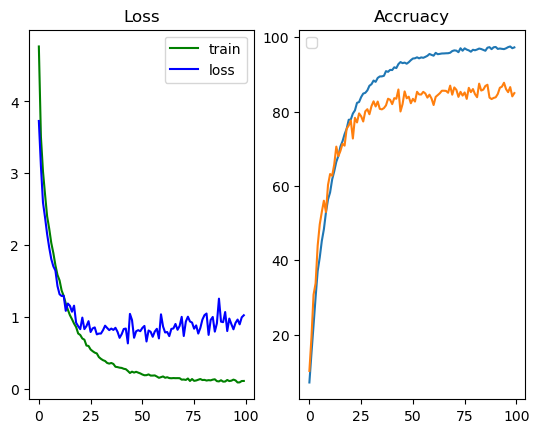

train acc: 97.28
valid acc: 84.99
test acc: 90.8


In [11]:
torch.cuda.empty_cache()
train_data_loader, valid_data_loader, test_data_loader = create_data_set(True)

VGG16_BDA = create_vgg16_model(is_batch=True, is_dropout= True)
details = create_model_details(VGG16_BDA, 100, lr=1e-3)
result = train_model(details, "VGG16_BDA")
show_result(result, "VGG16_BDA")

In [11]:
torch.cuda.empty_cache()
train_data_loader, valid_data_loader, test_data_loader = create_data_set(True)

VGG19_BDA = create_vgg19_model(is_batch=True, is_dropout= True)
details = create_model_details(VGG19_BDA, 100, lr=1e-3)
result = train_model(details, "VGG19_BDA")
show_result(result, "VGG19_BDA")

2023-01-05 08:35:54.524909: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


** Epoch 0 ** - Epoch Time 88
Train Loss = 5.0565
Train Accuracy = 3.087070202020202 % 

Val Loss = 4.0936
Val Accuracy = 4.672475 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


** Epoch 1 ** - Epoch Time 87
Train Loss = 3.9041
Train Accuracy = 9.116619696969696 % 

Val Loss = 3.4903
Val Accuracy = 16.09075 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


** Epoch 2 ** - Epoch Time 88
Train Loss = 3.4156
Train Accuracy = 16.464035353535355 % 

Val Loss = 3.0214
Val Accuracy = 22.1905 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


** Epoch 3 ** - Epoch Time 87
Train Loss = 3.025
Train Accuracy = 23.955533333333335 % 

Val Loss = 2.7885
Val Accuracy = 31.3852125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.30it/s]


** Epoch 4 ** - Epoch Time 87
Train Loss = 2.7252
Train Accuracy = 30.380162626262624 % 

Val Loss = 2.6569
Val Accuracy = 34.5102125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.35it/s]


** Epoch 5 ** - Epoch Time 87
Train Loss = 3.0028
Train Accuracy = 26.038357575757576 % 

Val Loss = 2.5485
Val Accuracy = 36.358175 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


** Epoch 6 ** - Epoch Time 86
Train Loss = 2.4015
Train Accuracy = 37.293550505050504 % 

Val Loss = 2.1134
Val Accuracy = 44.110575 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


** Epoch 7 ** - Epoch Time 86
Train Loss = 2.1881
Train Accuracy = 42.21244696969697 % 

Val Loss = 1.9991
Val Accuracy = 47.0102125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


** Epoch 8 ** - Epoch Time 87
Train Loss = 2.0127
Train Accuracy = 46.449118181818186 % 

Val Loss = 1.7611
Val Accuracy = 51.7427875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]


** Epoch 9 ** - Epoch Time 86
Train Loss = 1.8423
Train Accuracy = 50.52897929292929 % 

Val Loss = 1.7052
Val Accuracy = 54.4170625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


** Epoch 10 ** - Epoch Time 87
Train Loss = 1.7096
Train Accuracy = 53.8191898989899 % 

Val Loss = 1.6415
Val Accuracy = 57.9326875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.47it/s]


** Epoch 11 ** - Epoch Time 86
Train Loss = 1.6178
Train Accuracy = 55.830482323232324 % 

Val Loss = 1.5067
Val Accuracy = 58.0528875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.33it/s]


** Epoch 12 ** - Epoch Time 86
Train Loss = 1.4708
Train Accuracy = 59.52722777777778 % 

Val Loss = 1.3745
Val Accuracy = 63.97235 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  4.98it/s]


** Epoch 13 ** - Epoch Time 88
Train Loss = 1.4159
Train Accuracy = 61.14700454545454 % 

Val Loss = 1.3495
Val Accuracy = 65.204325 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.36it/s]


** Epoch 14 ** - Epoch Time 86
Train Loss = 1.6307
Train Accuracy = 56.345969696969696 % 

Val Loss = 1.4774
Val Accuracy = 62.03425 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]


** Epoch 15 ** - Epoch Time 86
Train Loss = 1.3662
Train Accuracy = 62.50076363636364 % 

Val Loss = 1.2843
Val Accuracy = 67.09735 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


** Epoch 16 ** - Epoch Time 87
Train Loss = 1.2702
Train Accuracy = 64.99445050505051 % 

Val Loss = 1.2321
Val Accuracy = 67.09735 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.32it/s]


** Epoch 17 ** - Epoch Time 87
Train Loss = 1.2058
Train Accuracy = 66.72470656565658 % 

Val Loss = 1.1626
Val Accuracy = 68.299275 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


** Epoch 18 ** - Epoch Time 86
Train Loss = 1.1155
Train Accuracy = 68.59497171717172 % 

Val Loss = 1.3508
Val Accuracy = 69.200725 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


** Epoch 19 ** - Epoch Time 87
Train Loss = 1.1203
Train Accuracy = 69.2410494949495 % 

Val Loss = 1.0986
Val Accuracy = 68.65985 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


** Epoch 20 ** - Epoch Time 87
Train Loss = 1.039
Train Accuracy = 71.0033808080808 % 

Val Loss = 1.1909
Val Accuracy = 67.9387 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


** Epoch 21 ** - Epoch Time 86
Train Loss = 0.9982
Train Accuracy = 72.3286287878788 % 

Val Loss = 1.1855
Val Accuracy = 69.53125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  4.94it/s]


** Epoch 22 ** - Epoch Time 87
Train Loss = 0.9267
Train Accuracy = 73.37513232323232 % 

Val Loss = 1.0294
Val Accuracy = 73.106975 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  4.99it/s]


** Epoch 23 ** - Epoch Time 87
Train Loss = 1.2362
Train Accuracy = 66.78045555555556 % 

Val Loss = 1.318
Val Accuracy = 69.74158750000001 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.30it/s]


** Epoch 24 ** - Epoch Time 87
Train Loss = 1.0287
Train Accuracy = 71.50104898989899 % 

Val Loss = 1.1768
Val Accuracy = 73.45252500000001 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


** Epoch 25 ** - Epoch Time 87
Train Loss = 0.9058
Train Accuracy = 74.28417222222222 % 

Val Loss = 1.1633
Val Accuracy = 70.9585375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


** Epoch 26 ** - Epoch Time 87
Train Loss = 0.8201
Train Accuracy = 76.85142777777777 % 

Val Loss = 1.1356
Val Accuracy = 73.482575 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]


** Epoch 27 ** - Epoch Time 87
Train Loss = 0.8112
Train Accuracy = 77.19712222222223 % 

Val Loss = 1.0148
Val Accuracy = 72.47596250000001 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


** Epoch 28 ** - Epoch Time 87
Train Loss = 0.9325
Train Accuracy = 75.44675606060605 % 

Val Loss = 1.147
Val Accuracy = 69.6364125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.31it/s]


** Epoch 29 ** - Epoch Time 87
Train Loss = 0.8441
Train Accuracy = 77.78108686868687 % 

Val Loss = 1.0703
Val Accuracy = 72.4609375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


** Epoch 30 ** - Epoch Time 87
Train Loss = 1.4985
Train Accuracy = 67.70476969696969 % 

Val Loss = 1.2799
Val Accuracy = 72.8064875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.32it/s]


** Epoch 31 ** - Epoch Time 87
Train Loss = 0.9686
Train Accuracy = 74.98803535353537 % 

Val Loss = 1.1224
Val Accuracy = 71.78485 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.34it/s]


** Epoch 32 ** - Epoch Time 86
Train Loss = 0.9003
Train Accuracy = 75.77514040404041 % 

Val Loss = 1.4
Val Accuracy = 64.6484375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


** Epoch 33 ** - Epoch Time 86
Train Loss = 0.9606
Train Accuracy = 74.3783601010101 % 

Val Loss = 1.3264
Val Accuracy = 69.050475 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.10it/s]


** Epoch 34 ** - Epoch Time 87
Train Loss = 0.9189
Train Accuracy = 75.64887777777778 % 

Val Loss = 1.5676
Val Accuracy = 63.34135 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]


** Epoch 35 ** - Epoch Time 87
Train Loss = 0.8022
Train Accuracy = 77.67849848484849 % 

Val Loss = 1.1556
Val Accuracy = 72.1304125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


** Epoch 36 ** - Epoch Time 87
Train Loss = 1.2351
Train Accuracy = 68.68966868686869 % 

Val Loss = 1.2639
Val Accuracy = 68.1340125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.37it/s]


** Epoch 37 ** - Epoch Time 86
Train Loss = 1.4571
Train Accuracy = 63.54930353535354 % 

Val Loss = 1.7192
Val Accuracy = 57.8726 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.01it/s]


** Epoch 38 ** - Epoch Time 87
Train Loss = 1.5836
Train Accuracy = 59.63821666666667 % 

Val Loss = 1.1366
Val Accuracy = 74.549275 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


** Epoch 39 ** - Epoch Time 87
Train Loss = 0.812
Train Accuracy = 77.35444141414142 % 

Val Loss = 1.0272
Val Accuracy = 73.4375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


** Epoch 40 ** - Epoch Time 87
Train Loss = 0.7679
Train Accuracy = 79.13357373737374 % 

Val Loss = 1.0467
Val Accuracy = 73.34735 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


** Epoch 41 ** - Epoch Time 87
Train Loss = 0.6041
Train Accuracy = 82.7605691919192 % 

Val Loss = 1.0464
Val Accuracy = 75.5859375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.30it/s]


** Epoch 42 ** - Epoch Time 87
Train Loss = 0.6239
Train Accuracy = 82.40800151515151 % 

Val Loss = 0.9705
Val Accuracy = 76.47235 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


** Epoch 43 ** - Epoch Time 87
Train Loss = 0.6686
Train Accuracy = 81.85407525252525 % 

Val Loss = 1.2155
Val Accuracy = 72.3107 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


** Epoch 44 ** - Epoch Time 87
Train Loss = 0.9189
Train Accuracy = 76.2901186868687 % 

Val Loss = 1.4192
Val Accuracy = 67.7283625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


** Epoch 45 ** - Epoch Time 87
Train Loss = 0.7656
Train Accuracy = 79.39042626262626 % 

Val Loss = 1.8346
Val Accuracy = 61.253 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


** Epoch 46 ** - Epoch Time 87
Train Loss = 0.9411
Train Accuracy = 75.47628484848485 % 

Val Loss = 1.1
Val Accuracy = 74.6845 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


** Epoch 47 ** - Epoch Time 94
Train Loss = 0.8347
Train Accuracy = 77.94986161616161 % 

Val Loss = 1.0249
Val Accuracy = 77.8846125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  4.95it/s]


** Epoch 48 ** - Epoch Time 87
Train Loss = 0.5378
Train Accuracy = 85.37364595959595 % 

Val Loss = 1.0166
Val Accuracy = 76.4272875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


** Epoch 49 ** - Epoch Time 87
Train Loss = 0.5289
Train Accuracy = 85.17050555555555 % 

Val Loss = 1.0604
Val Accuracy = 75.21033750000001 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


** Epoch 50 ** - Epoch Time 87
Train Loss = 0.4863
Train Accuracy = 86.88192424242423 % 

Val Loss = 0.9723
Val Accuracy = 76.5024 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.03it/s]


** Epoch 51 ** - Epoch Time 88
Train Loss = 0.4574
Train Accuracy = 87.18128888888889 % 

Val Loss = 1.0553
Val Accuracy = 77.5841375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


** Epoch 52 ** - Epoch Time 87
Train Loss = 0.4107
Train Accuracy = 88.76109898989898 % 

Val Loss = 0.9849
Val Accuracy = 77.9597375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  4.97it/s]


** Epoch 53 ** - Epoch Time 93
Train Loss = 0.3945
Train Accuracy = 88.9258005050505 % 

Val Loss = 1.204
Val Accuracy = 75.826325 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.47it/s]


** Epoch 54 ** - Epoch Time 88
Train Loss = 0.5383
Train Accuracy = 85.42939494949495 % 

Val Loss = 0.9951
Val Accuracy = 77.644225 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.35it/s]


** Epoch 55 ** - Epoch Time 86
Train Loss = 0.4954
Train Accuracy = 86.33843484848485 % 

Val Loss = 1.041
Val Accuracy = 75.78125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


** Epoch 56 ** - Epoch Time 86
Train Loss = 0.8368
Train Accuracy = 78.53382626262626 % 

Val Loss = 0.9936
Val Accuracy = 77.0883375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  4.78it/s]


** Epoch 57 ** - Epoch Time 88
Train Loss = 0.4212
Train Accuracy = 87.4732712121212 % 

Val Loss = 0.9875
Val Accuracy = 79.5823375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


** Epoch 58 ** - Epoch Time 88
Train Loss = 0.3078
Train Accuracy = 90.58452474747475 % 

Val Loss = 0.9451
Val Accuracy = 79.1766875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.31it/s]


** Epoch 59 ** - Epoch Time 89
Train Loss = 0.2788
Train Accuracy = 91.57782474747475 % 

Val Loss = 0.8909
Val Accuracy = 79.86778749999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.31it/s]


** Epoch 60 ** - Epoch Time 88
Train Loss = 0.2463
Train Accuracy = 92.61312727272727 % 

Val Loss = 0.9006
Val Accuracy = 81.580525 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


** Epoch 61 ** - Epoch Time 88
Train Loss = 0.2435
Train Accuracy = 92.85623383838383 % 

Val Loss = 1.0226
Val Accuracy = 82.0613 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


** Epoch 62 ** - Epoch Time 87
Train Loss = 0.2524
Train Accuracy = 92.49373787878788 % 

Val Loss = 0.7699
Val Accuracy = 84.6604625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


** Epoch 63 ** - Epoch Time 93
Train Loss = 0.2441
Train Accuracy = 92.85674292929292 % 

Val Loss = 0.9997
Val Accuracy = 79.387025 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


** Epoch 64 ** - Epoch Time 87
Train Loss = 0.2355
Train Accuracy = 92.95882222222222 % 

Val Loss = 0.8914
Val Accuracy = 81.6857 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


** Epoch 65 ** - Epoch Time 88
Train Loss = 0.2318
Train Accuracy = 93.1166505050505 % 

Val Loss = 0.9314
Val Accuracy = 80.513825 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


** Epoch 66 ** - Epoch Time 87
Train Loss = 0.2062
Train Accuracy = 93.74949090909091 % 

Val Loss = 0.9093
Val Accuracy = 81.1899 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.33it/s]


** Epoch 67 ** - Epoch Time 86
Train Loss = 0.2038
Train Accuracy = 93.97834191919192 % 

Val Loss = 1.06
Val Accuracy = 80.2283625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


** Epoch 68 ** - Epoch Time 87
Train Loss = 0.2316
Train Accuracy = 93.41754242424243 % 

Val Loss = 0.9569
Val Accuracy = 83.18809999999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


** Epoch 69 ** - Epoch Time 87
Train Loss = 0.2291
Train Accuracy = 93.47278232323232 % 

Val Loss = 0.952
Val Accuracy = 79.387025 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  4.93it/s]


** Epoch 70 ** - Epoch Time 87
Train Loss = 0.2261
Train Accuracy = 93.44070757575757 % 

Val Loss = 0.9784
Val Accuracy = 81.9260875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]


** Epoch 71 ** - Epoch Time 87
Train Loss = 0.2144
Train Accuracy = 93.5038388888889 % 

Val Loss = 0.8192
Val Accuracy = 80.64903749999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


** Epoch 72 ** - Epoch Time 87
Train Loss = 0.1822
Train Accuracy = 94.39607777777778 % 

Val Loss = 0.9948
Val Accuracy = 81.6857 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.32it/s]


** Epoch 73 ** - Epoch Time 86
Train Loss = 0.2033
Train Accuracy = 94.10409545454546 % 

Val Loss = 1.1808
Val Accuracy = 79.236775 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


** Epoch 74 ** - Epoch Time 88
Train Loss = 0.1843
Train Accuracy = 94.49077474747475 % 

Val Loss = 0.9256
Val Accuracy = 82.5721125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


** Epoch 75 ** - Epoch Time 88
Train Loss = 0.201
Train Accuracy = 93.97783282828283 % 

Val Loss = 0.9237
Val Accuracy = 82.21153749999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


** Epoch 76 ** - Epoch Time 88
Train Loss = 0.1914
Train Accuracy = 94.14406161616162 % 

Val Loss = 0.9829
Val Accuracy = 84.2247625 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.30it/s]


** Epoch 77 ** - Epoch Time 86
Train Loss = 0.1883
Train Accuracy = 94.56968888888889 % 

Val Loss = 0.8841
Val Accuracy = 82.78245 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.32it/s]


** Epoch 78 ** - Epoch Time 86
Train Loss = 0.3949
Train Accuracy = 89.57289646464646 % 

Val Loss = 0.8518
Val Accuracy = 83.173075 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


** Epoch 79 ** - Epoch Time 86
Train Loss = 0.2099
Train Accuracy = 93.70952474747475 % 

Val Loss = 0.9483
Val Accuracy = 82.3768 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.30it/s]


** Epoch 80 ** - Epoch Time 86
Train Loss = 0.1705
Train Accuracy = 95.20202020202021 % 

Val Loss = 1.0829
Val Accuracy = 81.1899 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


** Epoch 81 ** - Epoch Time 86
Train Loss = 0.1526
Train Accuracy = 95.43774444444445 % 

Val Loss = 0.8806
Val Accuracy = 83.3233125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.33it/s]


** Epoch 82 ** - Epoch Time 86
Train Loss = 0.1603
Train Accuracy = 95.45403636363636 % 

Val Loss = 0.9673
Val Accuracy = 81.3852125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.30it/s]


** Epoch 83 ** - Epoch Time 86
Train Loss = 0.1476
Train Accuracy = 95.65030353535353 % 

Val Loss = 0.9373
Val Accuracy = 80.889425 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


** Epoch 84 ** - Epoch Time 86
Train Loss = 0.159
Train Accuracy = 95.35832121212121 % 

Val Loss = 1.2637
Val Accuracy = 79.266825 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


** Epoch 85 ** - Epoch Time 87
Train Loss = 0.1597
Train Accuracy = 95.29620808080809 % 

Val Loss = 0.9357
Val Accuracy = 82.60216249999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


** Epoch 86 ** - Epoch Time 87
Train Loss = 0.167
Train Accuracy = 95.22416717171717 % 

Val Loss = 0.9373
Val Accuracy = 83.57872499999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


** Epoch 87 ** - Epoch Time 86
Train Loss = 0.1521
Train Accuracy = 95.58768131313131 % 

Val Loss = 0.9515
Val Accuracy = 83.3683875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


** Epoch 88 ** - Epoch Time 87
Train Loss = 0.1445
Train Accuracy = 95.7281994949495 % 

Val Loss = 1.1139
Val Accuracy = 80.87440000000001 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.36it/s]


** Epoch 89 ** - Epoch Time 86
Train Loss = 0.1703
Train Accuracy = 95.38352272727273 % 

Val Loss = 0.7588
Val Accuracy = 84.074525 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


** Epoch 90 ** - Epoch Time 86
Train Loss = 0.1473
Train Accuracy = 95.45403636363636 % 

Val Loss = 1.0135
Val Accuracy = 82.3016875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


** Epoch 91 ** - Epoch Time 86
Train Loss = 0.1598
Train Accuracy = 95.45352727272727 % 

Val Loss = 1.0705
Val Accuracy = 82.6472375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


** Epoch 92 ** - Epoch Time 86
Train Loss = 0.1302
Train Accuracy = 96.07007575757575 % 

Val Loss = 1.0266
Val Accuracy = 83.7590125 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


** Epoch 93 ** - Epoch Time 86
Train Loss = 0.1499
Train Accuracy = 95.6897606060606 % 

Val Loss = 0.9917
Val Accuracy = 84.014425 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


** Epoch 94 ** - Epoch Time 86
Train Loss = 0.1429
Train Accuracy = 95.83231515151515 % 

Val Loss = 0.9878
Val Accuracy = 83.27825 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]


** Epoch 95 ** - Epoch Time 86
Train Loss = 0.1482
Train Accuracy = 95.71445303030303 % 

Val Loss = 1.0006
Val Accuracy = 82.106375 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


** Epoch 96 ** - Epoch Time 87
Train Loss = 0.1306
Train Accuracy = 96.07745808080809 % 

Val Loss = 1.0396
Val Accuracy = 81.43028749999999 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  4.96it/s]


** Epoch 97 ** - Epoch Time 86
Train Loss = 0.1358
Train Accuracy = 96.08585858585859 % 

Val Loss = 0.9492
Val Accuracy = 81.730775 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


** Epoch 98 ** - Epoch Time 86
Train Loss = 0.1245
Train Accuracy = 96.07745808080809 % 

Val Loss = 1.1497
Val Accuracy = 82.1814875 % 



100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.00it/s]


** Epoch 99 ** - Epoch Time 86
Train Loss = 0.1527
Train Accuracy = 95.69917929292929 % 

Val Loss = 1.0931
Val Accuracy = 80.5739125 % 



 10%|████▍                                       | 1/10 [00:00<00:02,  3.58it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 308.00 MiB (GPU 0; 23.68 GiB total capacity; 18.36 GiB already allocated; 307.81 MiB free; 19.79 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

100%|███████████████████████████████████████████| 10/10 [00:28<00:00,  2.85s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


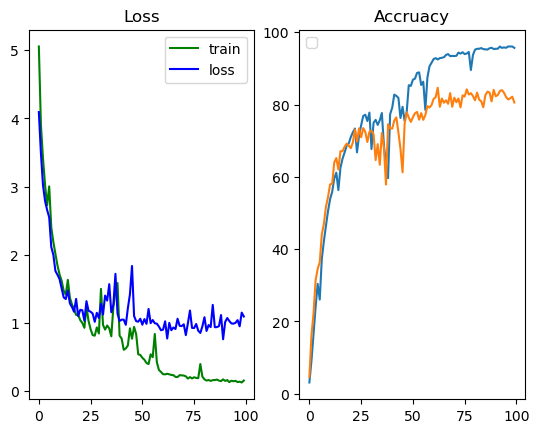

train acc: 95.7
valid acc: 80.57
test acc: 87.4


In [20]:
result['model'].cpu()
show_result(result, "VGG19_BDA")